In [1]:
import pandas as pd #Analysis 
import matplotlib.pyplot as plt #Visulization
import seaborn as sns #Visulization
import numpy as np #Analysis 
import warnings 
warnings.filterwarnings('ignore')
%matplotlib inline
color = sns.color_palette()

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

import eli5
from eli5.sklearn import PermutationImportance

import shap

/usr/local/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
plt.rcParams["figure.facecolor"] = 'w'
plt.rcParams["font.family"] = 'NanumBarunGothic'
plt.rcParams['axes.unicode_minus'] = False

In [3]:
train = pd.read_csv("../../data/credit_card_data.csv")
train.shape

(3888, 26)

데이터에서 NaN으로 표현된 부분을 처리하고 데이터 타입을 정리한다.
- 성별 통계는 전국에 대한 통계이므로 city란을 전국으로 처리
- 지역별 통계에서는 남여 전체에 대한 통계이므로 city란을 전국으로 처리
- 나이별 통계는 연산의 용이성을 위해 숫자로 변환
- 연도, 월 데이터는 python의 datetime포맷으로 변환하여 새로운 열 year_month로 변환

In [4]:
train['city'] = train['city'].fillna('전국')
train['sex'] = train['sex'].fillna('전체')
train['ages'] = train['ages'].apply(lambda x:int(x[:-1])).astype(float)
train['year_month'] = pd.to_datetime((train.year*100+train.month).apply(str),format='%Y%m')
train.drop(['year','month'], axis=1, inplace=True)
train = train[[train.columns[0],'year_month']+list(train.columns[1:-1])]

In [6]:
train.head()

,pop_cd,year_month,avg_score,avg_rat,city,sex,ages,population,num_opencard,num_usecard,...,monthly_installments_loan,monthly_insurance_loan,monthly_sbk_loan,loan_commitment,inst_rep_loanb,ls_rep_loanb,credit_loan,mortgage_loan,credit_card_payment,credit_card_installments_payment
0,L011,2016-01-01,812,2,서울,전체,10.0,55000,1.44,1.13,...,0,0,0,1120000,8210000,78020000,92170000,87260000,0,0
1,L011,2016-02-01,773,4,서울,전체,10.0,380000,1.71,0.96,...,510000,220000,1020000,680000,4660000,23300000,8260000,42410000,4000,1000
2,L011,2016-03-01,771,4,서울,전체,10.0,387000,1.75,0.95,...,490000,210000,1140000,640000,4370000,22930000,8300000,41710000,3000,1000
3,L011,2016-04-01,770,4,서울,전체,10.0,412000,1.76,0.92,...,510000,240000,1340000,510000,4770000,22160000,9460000,41040000,4000,1000
4,L011,2016-05-01,771,4,서울,전체,10.0,414000,1.75,0.94,...,490000,340000,1490000,640000,4740000,21960000,9660000,40850000,3000,1000


#### 유니크 갯수 계산을 통한 변수 값의 다양성 분석

In [7]:
train_unique = []
for i in train.columns.values:
    train_unique.append(len(train[i].unique()))
unique_train = pd.DataFrame()
unique_train['Columns'] = list(train.columns)
unique_train['Unique_value'] = train_unique

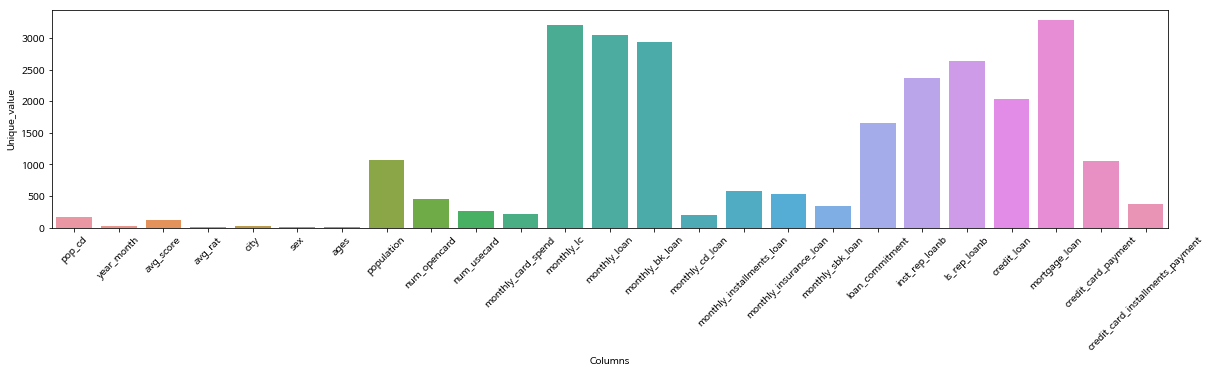

In [8]:
plt.figure(figsize=(20,4))
sns.barplot(unique_train['Columns'], unique_train['Unique_value'])
xt = plt.xticks()
_ = plt.xticks(xt[0], train.columns, rotation=45)

## 상관관계 분석
데이터 컬럼 사이의 상관관계를 계산해 비례함의 정도를 보인다.  
양의 상관관계가 클수록 비례관계, 음의 상관관계가 클수록 반비례 관계이며 0에 가까우면 서로 독립으로 볼 수 있다.

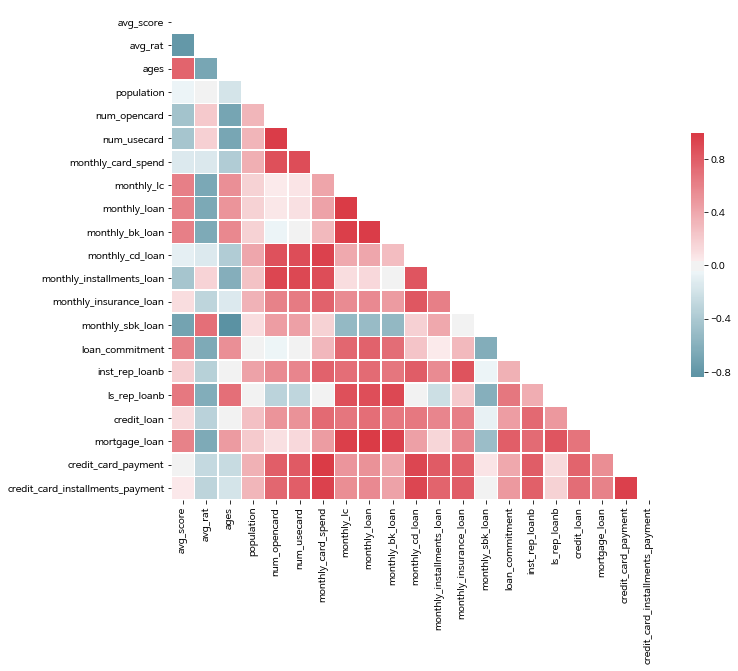

In [9]:
corr = train.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

In [10]:
corr = train.corr().unstack().sort_values(ascending=False).drop_duplicates().drop_duplicates()
corr.drop(corr.index[0],inplace=True)
display(corr.head())
display(corr.tail(5))

monthly_loan         monthly_lc            0.986415
credit_card_payment  monthly_card_spend    0.985854
mortgage_loan        monthly_loan          0.985699
num_usecard          num_opencard          0.983744
monthly_loan         monthly_bk_loan       0.980280
dtype: float64

ages              num_usecard        -0.679487
num_opencard      ages               -0.688015
avg_score         monthly_sbk_loan   -0.701963
avg_rat           avg_score          -0.786341
monthly_sbk_loan  ages               -0.841758
dtype: float64

가장 상관관계가 높은 5쌍은 아래와 같다
- monthly_loan, monthly_lc:   
대출금액은 대출약정금액에 포함되므로 상관관계가 1에 가깝다는 것은 대출약정이 많을수록 대출 발생도 많이 했으므로, 마이너스 통장과 같은 대출 발생 금액은 상대적으로 적다고 할 수 있다.
- credit_card_payment, monthly_card_spend:  
신용카드 사용 금액은 총 카드 승인 금액에 포함되므로 상관관계가 1에 가깝다는 것은 체크카드 사용량이 적다는 것을 알 수 있다.
- mortgage_loan, monthly_loan:  
담보대출은 대출금액에 포함되므로 상관관계가 1에 가깝다는 것은 대출이 많을수록 담보대출도 많아지므로 대출의 상당수가 담보대출이라고 생각할 수 있다.
- num_usecard, num_opencard:  
개설한 카드 수와 사용 카드 수가 비례하므로 유휴 카드가 많지 않다고 해석할 수 있다.
- monthly_loan, monthly_bk_loan:  
은행대출은 대출금액에 포함되므로 상관관계가 1에 가깝다는 것은 대출의 상당수가 은행대출이라는 것을 알 수 있다.

가장 상관관계가 낮은 5쌍은 아래와 같다
- ages, num_usecard:  
상관관계에 따르면 나이가 높을수록 사용하는 카드의 수가 적다. 고령으로 갈수록 필요한 카드만 사용한다고 볼 수 있다.
- num_opencard, ages:  
나이와 사용카드의 관계와 동일하게 해석 가능하다
- avg_score, monthly_sbk_loan:  
저축은행 대출이 낮을수록 신용점수가 높다.
- avg_rat, avg_score:  
신용점수가 높을수록 높은 등급을 받는 것은 당연하지만, 등급이 높을수록 숫자가 낮아 음의 상관관계를 가진다.
- monthly_sbk_loan, ages:  
나이가 낮을수록 저축은행 대출이 높다.

### 연령별/지역별 상관관계 분석
전체 데이터의 상관관계가 연령, 지역별로도 적용되는지 확인하기 위해 데이터를 그룹에 따라 모아서 평균 신용점수(avg_score)에 대해서만 상관관계를 분석해보았다.

#### 연령별 상관관계 분석

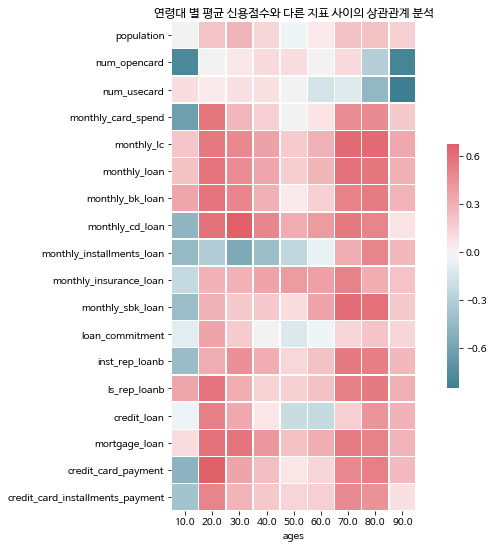

In [11]:
corr = train[train.columns[1:]].groupby('ages').corr()['avg_score'].fillna(0).unstack()
mask = np.zeros_like(corr, dtype=np.bool)

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr.T[2:],  cmap=cmap,  center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('연령대 별 평균 신용점수와 다른 지표 사이의 상관관계 분석')
plt.show()

#### 지역별 상관관계 분석

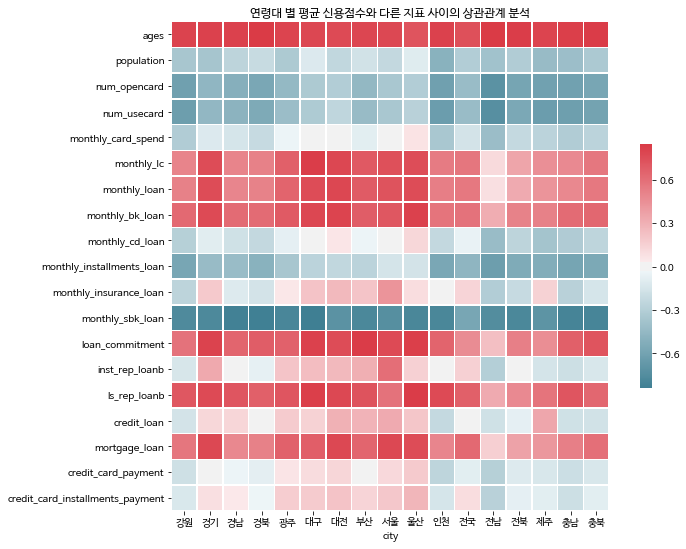

In [12]:
corr = train[train.columns[1:]].groupby('city').corr()['avg_score'].fillna(0).unstack()
mask = np.zeros_like(corr, dtype=np.bool)
# mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr.T[2:],  cmap=cmap,  center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('연령대 별 평균 신용점수와 다른 지표 사이의 상관관계 분석')
plt.show()

위 분석에 따르면 신용점수와의 상관관계는 지역에 따라서는 큰 편차가 없지만 연령에 따라서는 편차가 큰 것으로 보인다.

## 신용점수 예측모델 학습 및 분석
신용점수를 예측하는 모델을 학습하여 신용도에 영향을 많이 주는 요소를 분석한다.
- 예측 목표: 'avg_score'
- 학습에 사용되는 요소: 'num_opencard', 'num_usecard', 'monthly_card_spend', 'monthly_lc', 'monthly_loan', 'monthly_bk_loan', 'monthly_cd_loan', 'monthly_installments_loan', 'monthly_insurance_loan', 'monthly_sbk_loan', 'loan_commitment', 'inst_rep_loanb', 'ls_rep_loanb', 'credit_loan', 'mortgage_loan', 'credit_card_payment', 'credit_card_installments_payment'
- 학습에서 제외된 요소: 'pop_cd', 'city', 'ages', 'sex', 'year_month', 'population', 'avg_rat'

### 변수 중요도 분석
- Feature Importance: 해당 요소가 데이터를 학습 목적에 맞게 얼마나 잘 나누는지
- Permutation Importance: 해당 요소의 값만 다른 샘플과 임의로 바꾸었을 때 예측 성능이 감소하는 정도

In [13]:
from sklearn.model_selection import train_test_split

target = 'avg_score'
cols_to_drop = ['pop_cd','city','ages', 'sex', 'year_month', 'population','avg_rat', target]
cols_to_fit = [col for col in train.columns if col not in cols_to_drop]
train_split, val_split = train_test_split(train, test_size=0.3)

### LightGBM을 사용한 학습

[10]	valid_0's l2: 46.9211	valid_0's l1: 4.79089
[20]	valid_0's l2: 30.1525	valid_0's l1: 3.74772
[30]	valid_0's l2: 24.2212	valid_0's l1: 3.22357
[40]	valid_0's l2: 20.1294	valid_0's l1: 2.8944
[50]	valid_0's l2: 18.656	valid_0's l1: 2.71345
[60]	valid_0's l2: 17.4798	valid_0's l1: 2.5674
[70]	valid_0's l2: 16.3687	valid_0's l1: 2.44498
[80]	valid_0's l2: 15.7405	valid_0's l1: 2.37392
[90]	valid_0's l2: 15.3763	valid_0's l1: 2.30938
[100]	valid_0's l2: 15.0546	valid_0's l1: 2.26535


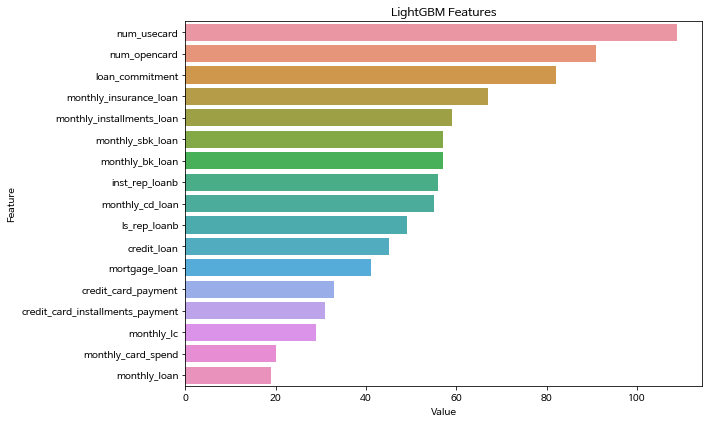

Weight,Feature
1.1674 ± 0.0386,num_usecard
0.1932 ± 0.0142,ls_rep_loanb
0.1849 ± 0.0146,monthly_bk_loan
0.1710 ± 0.0084,monthly_cd_loan
0.1698 ± 0.0167,monthly_installments_loan
0.1222 ± 0.0056,num_opencard
0.1139 ± 0.0078,monthly_sbk_loan
0.0512 ± 0.0140,monthly_card_spend
0.0331 ± 0.0037,inst_rep_loanb
0.0297 ± 0.0033,credit_card_payment


In [14]:
from lightgbm import LGBMRegressor
params = {
    'n_estimators': 100,
    'learning_rate': 0.3, 
    'num_leaves': 10,
    'objective': 'regression_l2', 
    'metric': ['mae', 'mse'],
    'verbose': -1,
}

lgbm_model = LGBMRegressor(**params)
lgbm_model.fit(
    train_split[cols_to_fit], train_split[target],
    eval_set=[(val_split[cols_to_fit], val_split[target])],
    eval_metric=['mae', 'mse'],
    verbose=10,
)

feature_importance = pd.DataFrame(sorted(zip(lgbm_model.feature_importances_, cols_to_fit)), columns=['Value','Feature'])

plt.figure(figsize=(10, 6))
sns.barplot(x="Value", y="Feature", data=feature_importance.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()

perm = PermutationImportance(lgbm_model).fit(val_split[cols_to_fit], val_split[target])
eli5.show_weights(perm, feature_names=list(cols_to_fit))

[0]	validation_0-rmse:560.865
[10]	validation_0-rmse:18.3575
[20]	validation_0-rmse:6.78511
[30]	validation_0-rmse:5.76178
[40]	validation_0-rmse:5.21703
[50]	validation_0-rmse:4.77109
[60]	validation_0-rmse:4.46686
[70]	validation_0-rmse:4.2848
[80]	validation_0-rmse:4.1057
[90]	validation_0-rmse:3.98019
[99]	validation_0-rmse:3.85183


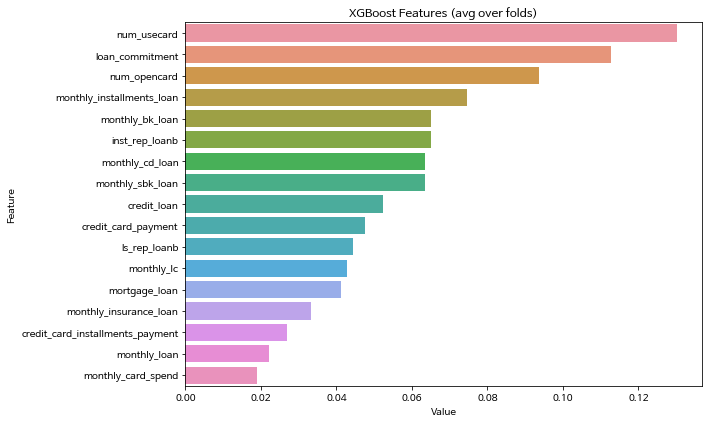

Weight,Feature
1.7981 ± 0.0367,num_usecard
0.3112 ± 0.0341,monthly_cd_loan
0.2680 ± 0.0177,monthly_installments_loan
0.2227 ± 0.0314,monthly_sbk_loan
0.0985 ± 0.0103,ls_rep_loanb
0.0967 ± 0.0032,credit_card_payment
0.0886 ± 0.0102,num_opencard
0.0750 ± 0.0046,monthly_bk_loan
0.0586 ± 0.0072,loan_commitment
0.0585 ± 0.0083,inst_rep_loanb


In [15]:
from xgboost import XGBRegressor
params = {
    'n_estimators': 100,
    'learning_rate': 0.3, 
    'num_leaves': 10,
    'verbose': -1,
}

xgb_model = XGBRegressor(**params)
xgb_model.fit(
    train_split[cols_to_fit], train_split[target],
    eval_set=[(val_split[cols_to_fit], val_split[target])],
    verbose=10,
)

feature_importance = pd.DataFrame(sorted(zip(xgb_model.feature_importances_, cols_to_fit)), columns=['Value','Feature'])

plt.figure(figsize=(10, 6))
sns.barplot(x="Value", y="Feature", data=feature_importance.sort_values(by="Value", ascending=False))
plt.title('XGBoost Features (avg over folds)')
plt.tight_layout()
plt.show()

perm = PermutationImportance(xgb_model).fit(val_split[cols_to_fit], val_split[target])
eli5.show_weights(perm, feature_names=list(cols_to_fit))

학습/검증 데이터를 다양하게 분배하고 모델 파라미터를 여러가지로 조정해본 결과 공통적으로 중요하게 여겨지는 변수는
- num_usecard
- monthly_installments_loan
- monthly_cd_loan

공통적으로 중요치 않게 여겨지는 변수는
- monthly_loan

 따라서 사용 카드 갯수가 신용도 예측에 가장 큰 영향을 준 것을 알 수 있다.

### SHAP 중요도 분석
위의 중요도로는 변수가 얼마나 영향을 주는지만 알 수 있을 뿐, 신용도를 높이거나 낮추는 데에는 어떤 영향이 있는지 알 수 없다.
SHAP를 사용해 변수의 값이 높을/낮을 때 신용도가 올라가는지 내려가는지를 보인다.

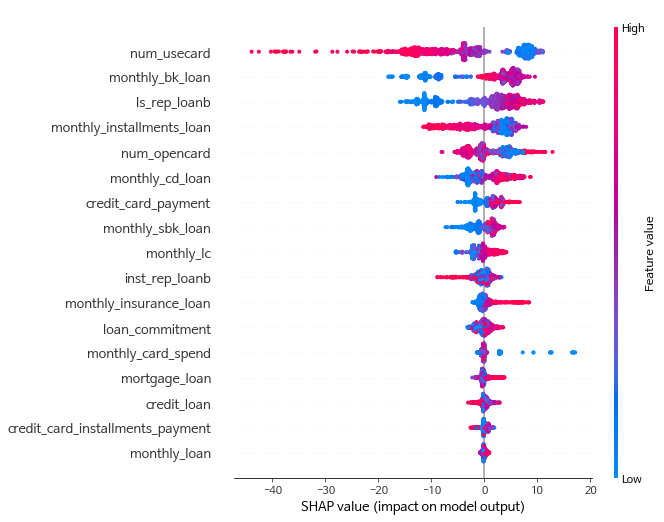

In [16]:
explainer = shap.TreeExplainer(lgbm_model)
shap_values = explainer.shap_values(val_split[cols_to_fit])
shap.summary_plot(shap_values, val_split[cols_to_fit])

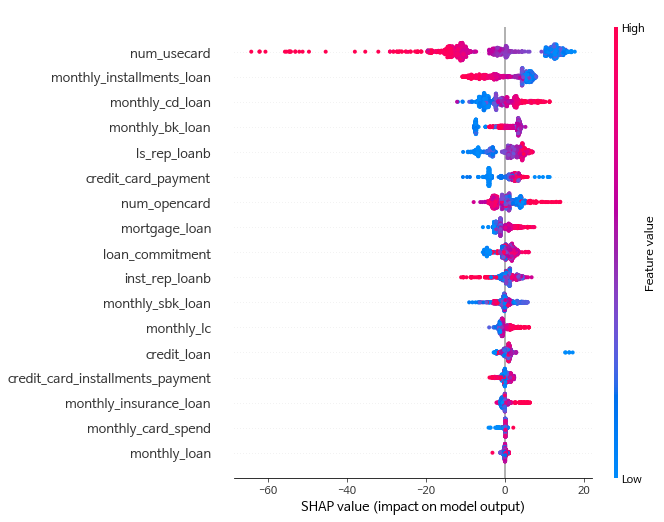

In [17]:
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(val_split[cols_to_fit])
shap.summary_plot(shap_values, val_split[cols_to_fit])

SHAP 분석에 따르면 사용 카드가 많을수록 신용도가 낮고 적을수록 높다고 예측한다.  
하지만 사용카드의 수가 너무 큰 영향을 끼치는 것으로 보이기에 'num_usecard'와 'num_opencard'를 제외하고 다시 학습을 진행한다.

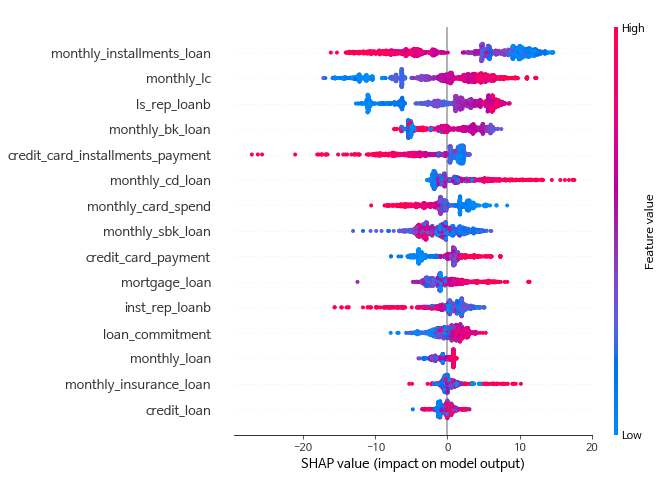

In [18]:
target = 'avg_score'
cols_to_drop = ['pop_cd','city','ages', 'sex', 'year_month', 'population','avg_rat', target]+['num_usecard', 'num_opencard']
cols_to_fit = [col for col in train.columns if col not in cols_to_drop]
train_split, val_split = train_test_split(train, test_size=0.3)

xgb_model = XGBRegressor(**params)
xgb_model.fit(
    train_split[cols_to_fit], train_split[target],
    eval_set=[(val_split[cols_to_fit], val_split[target])],
    verbose=0,
)

feature_importance = pd.DataFrame(sorted(zip(xgb_model.feature_importances_, cols_to_fit)), columns=['Value','Feature'])

explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(val_split[cols_to_fit])
shap.summary_plot(shap_values, val_split[cols_to_fit])

나머지 변수들을 토대로 신용도를 추정하자면 비례관계가 불확실한(값의 높고 낮음이 혼재된) 변수를 제외하면
- 할부금융 대출이 적을수록
- 일시상환대출 잔여금액이 많을수록
- 월간 카드 사용량이 적을수록
- 월간 카드 대출량이 많을수록
- 신용카드 사용금액이 적을수록
- 대출금액 총합이 많을수록

신용도가 높게 추정된다.